In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import scipy
import requests
import json

In [4]:
comp_token_decimals = {
    'COMP': 10**18,
    'cCOMP': 10**8,
    'cWETHv3': 10**18,
    'cUSDTv3': 10**6,
    'cUSDCv3': 10**6
}

comp_tokens = ['COMP', 'cCOMP', 'cWETHv3', 'cUSDTv3', 'cUSDCv3']

aave_token_decimals = {
    'AAVE': 10**18,
    'stkAAVE': 10**18,
    'aEthAAVE': 10**18,
    'aEthWETH': 10**18,
    'aEthUSDT': 10**6,
    'aEthUSDC': 10**6
}

aave_tokens = ['AAVE', 'stkAAVE', 'aEthAAVE', 'aEthWETH', 'aEthUSDT', 'aEthUSDC']

def scale_transfer_value(token):
    df = pd.read_csv(f'data/aave/{token}.csv')
    df['value'] = df['value'].astype(float) / aave_token_decimals[token]
    df.to_csv(f'data/aave/{token}.csv', index=False)
    
for token in aave_tokens:
    scale_transfer_value(token)

In [11]:
with open('data/proposals/compound_proposals.json', 'r', encoding="utf8") as f:
    proposals_data = json.load(f)
    
with open('data/proposals/compound_votes.json', 'r', encoding="utf8") as f:
    votes_data = json.load(f)

In [12]:
def scale_proposals(proposals_data):
    for proposal in proposals_data['data']['proposals']:
        proposal['abstainWeightedVotes'] = str(int(proposal['abstainWeightedVotes']) / 10**18)
        proposal['againstWeightedVotes'] = str(int(proposal['againstWeightedVotes']) / 10**18)
        proposal['forWeightedVotes'] = str(int(proposal['forWeightedVotes']) / 10**18)
        proposal['quorumVotes'] = str(int(proposal['quorumVotes']) / 10**18)
        proposal['totalWeightedVotes'] = str(int(proposal['totalWeightedVotes']) / 10**18)
    return proposals_data

scaled_proposals = scale_proposals(proposals_data)

with open('data/proposals/compound_scaled_proposals.json', 'w') as f:
    json.dump(scaled_proposals, f, indent=4)

In [13]:
def scale_votes(votes_data):
    for proposal in votes_data:
        for vote in proposal['votes']:
            vote['weight'] = str(int(vote['weight']) / 10**18)
    return votes_data

scaled_votes = scale_votes(votes_data)

with open('data/proposals/compound_scaled_votes.json', 'w') as f:
    json.dump(scaled_votes, f, indent=4)

In [16]:
aave_tokens = ['AAVE', 'stkAAVE', 'aEthAAVE', 'aEthWETH', 'aEthUSDT', 'aEthUSDC']
comp_tokens = ['COMP', 'cCOMP', 'cWETHv3', 'cUSDTv3', 'cUSDCv3']

df_list = []

for token in aave_tokens:
    df = pd.read_csv(f'data/aave/{token}.csv')
    df['token'] = token
    
    df_list.append(df)
    
for token in comp_tokens:
    df = pd.read_csv(f'data/compound/{token}.csv')
    df['token'] = token
    
    df_list.append(df)
    
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv('data/combined_transfers.csv', index=False)

In [5]:
transfers_df = pd.read_csv('data/combined_transfers.csv')
address_type_df = pd.read_csv('data/node_table.csv')

In [6]:
G = nx.Graph()

for _, row in transfers_df.iterrows():
    from_address = row['from']
    to_address = row['to']
    
    G.add_edge(from_address, to_address)

address_type_dict = pd.Series(address_type_df['type'].values, index=address_type_df['address']).to_dict()

nx.set_node_attributes(G, address_type_dict, 'type')

In [7]:
address_type_df['type'].value_counts().reset_index(name='node_count')

,type,node_count
0,False,313557
1,True,15817


In [8]:
eoa_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == False]
sc_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == True]

eoa_degrees = [G.degree(n) for n in eoa_nodes]
sc_degrees = [G.degree(n) for n in sc_nodes]

avg_degree_eoa = sum(eoa_degrees) / len(eoa_degrees) if len(eoa_degrees) > 0 else 0
avg_degree_sc = sum(sc_degrees) / len(sc_degrees) if len(sc_degrees) > 0 else 0

print(f'Average degree of EOAs: {avg_degree_eoa}')
print(f'Average degree of smart contracts: {avg_degree_sc}')

Average degree of EOAs: 2.7677551449975604
Average degree of smart contracts: 15.361383321742428


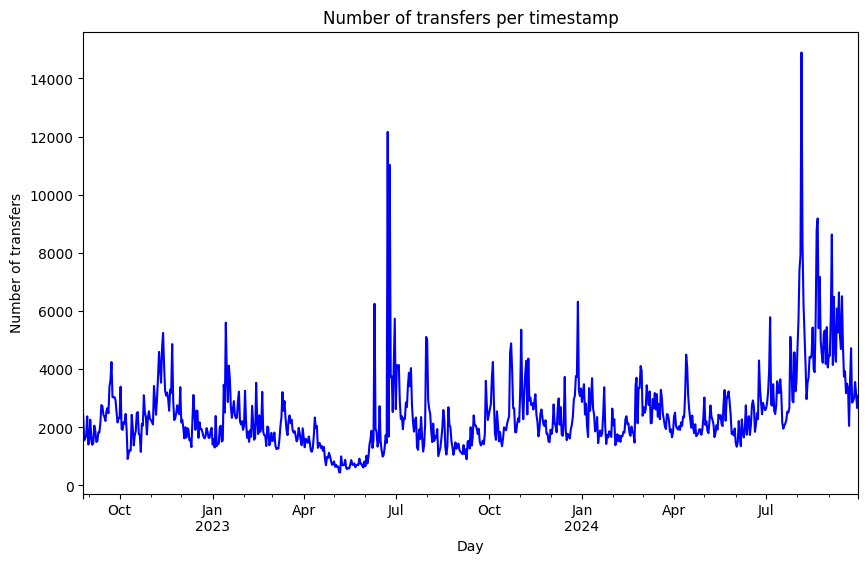

In [25]:
transfers_df['timestamp'] = pd.to_datetime(transfers_df['timestamp'], unit='s')

transfers_per_day = transfers_df.resample('D', on='timestamp').size()

plt.figure(figsize=(10, 6))
transfers_per_day.plot(kind='line', color='blue', title='Number of transfers per timestamp')
plt.xlabel('Day')
plt.ylabel('Number of transfers')
plt.show()

In [12]:
degree_list = sorted(G.degree, key=lambda x: x[1], reverse=True)

degree_df = pd.DataFrame(degree_list, columns=['Address', 'Degree'])

print(degree_df)

                                           Address  Degree
0       0x0000000000000000000000000000000000000000   61080
1       0x28c6c06298d514db089934071355e5743bf21d60   40986
2       0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43   34001
3       0xdfd5293d8e347dfe59e90efd55b2956a1343963d   19527
4       0x21a31ee1afc51d94c2efccaa2092ad1028285549   19222
...                                            ...     ...
329369  0x780f32fe419d276786a7ffe1fbb0d0cdb1865ccc       1
329370  0x7f7e2f02d7125f9ad99d1dcedb99d01e1f29d9cd       1
329371  0x5c086177828a54855c1a7913f2a0616d122b9bd3       1
329372  0x8fd589aa8bfa402156a6d1ad323fec0ecee50d9d       1
329373  0x762f7a3e0b6de7eea50a5469d4ac19acd274e508       1

[329374 rows x 2 columns]


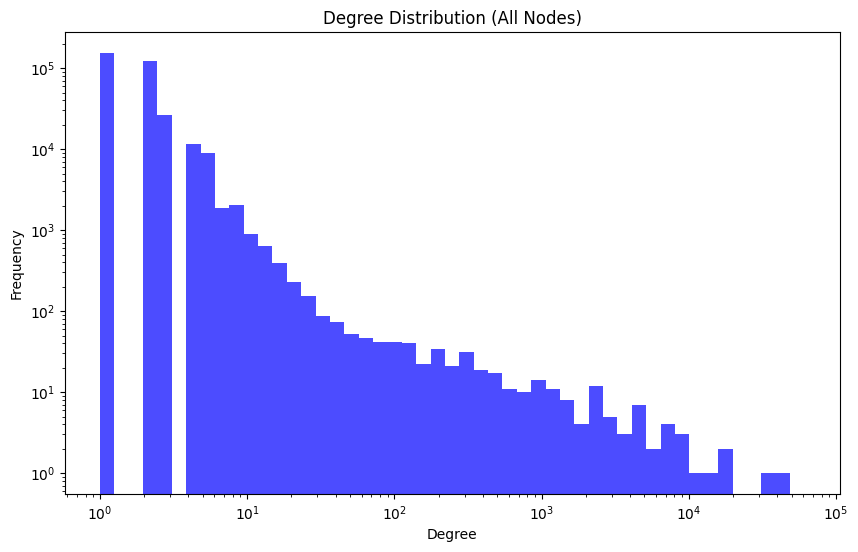

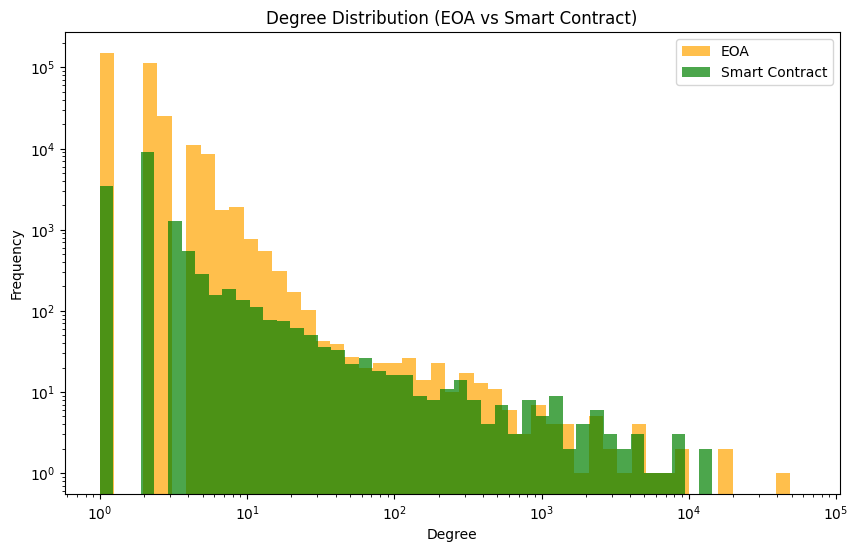

In [26]:
degrees = [G.degree(n) for n in G.nodes()]

eoa_degrees = [G.degree(n) for n, attr in G.nodes(data=True) if attr['type'] == False]
sc_degrees = [G.degree(n) for n, attr in G.nodes(data=True) if attr['type'] == True]

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 50), color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (All Nodes)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(eoa_degrees, bins=np.logspace(np.log10(1), np.log10(max(eoa_degrees)), 50), color='orange', alpha=0.7, label='EOA')
plt.hist(sc_degrees, bins=np.logspace(np.log10(1), np.log10(max(sc_degrees)), 50), color='green', alpha=0.7, label='Smart Contract')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (EOA vs Smart Contract)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [27]:
connected_components = list(nx.connected_components(G))

largest_component = max(connected_components, key=len)
largest_subgraph = G.subgraph(largest_component)

print(f"Largest component size: {len(largest_component)}")

Largest component size: 318099


In [ ]:
# clustering_coefficient = nx.clustering(G)
average_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {average_clustering}")

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
print(f"Betweenness centrality of a sample node: {list(betweenness_centrality.items())[:5]}")

In [ ]:
# Calculate degree assortativity (correlation between node degrees)
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity: {degree_assortativity}")